In [17]:
import os
import numpy as np
import cv2
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from skimage.feature import graycomatrix, graycoprops

In [18]:
# Reproducibility
random.seed(20)
np.random.seed(20)
tf.random.set_seed(20)

In [19]:
benign_path = r"E:\IQ-OTHNCCD _Lung _Cancer_Dataset\Benign cases"
malignant_path = r"E:\IQ-OTHNCCD _Lung _Cancer_Dataset\Malignant cases"
normal_path = r"E:\IQ-OTHNCCD _Lung _Cancer_Dataset\Normal cases"


In [20]:
def load_images_from_folder(folder, label, img_size=(64, 64)):
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)
            labels.append(label)
    return images, labels


In [21]:
benign_images, benign_labels = load_images_from_folder(benign_path, 0)
malignant_images, malignant_labels = load_images_from_folder(malignant_path, 1)
normal_images, normal_labels = load_images_from_folder(normal_path, 2)

In [22]:
X = np.array(benign_images + malignant_images + normal_images)
y = np.array(benign_labels + malignant_labels + normal_labels)


In [23]:
# SMOTE
X_flattened = X.reshape(X.shape[0], -1)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_flattened, y)

In [24]:
# Normalize after SMOTE
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
y_resampled = to_categorical(y_resampled, num_classes=3)

In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [36]:
# CNN Model 
model = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


In [52]:
# Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32,
                    callbacks=[early_stopping, lr_scheduler])

# Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.6471 - loss: 2.3798 - val_accuracy: 0.8843 - val_loss: 1.9808 - learning_rate: 0.0010
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9191 - loss: 1.6716 - val_accuracy: 0.9614 - val_loss: 1.5004 - learning_rate: 0.0010
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.9691 - loss: 1.4602 - val_accuracy: 0.9941 - val_loss: 1.2991 - learning_rate: 0.0010
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9896 - loss: 1.2942 - val_accuracy: 0.9852 - val_loss: 1.1928 - learning_rate: 0.0010
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9940 - loss: 1.1545 - val_accuracy: 0.9941 - val_loss: 1.0534 - learning_rate: 0.0010
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9904 - loss: 1.0452 - val_accuracy: 0.9970 - val_loss: 0.9482 - learning_rate: 0.0010
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9840 - loss: 0.9648 

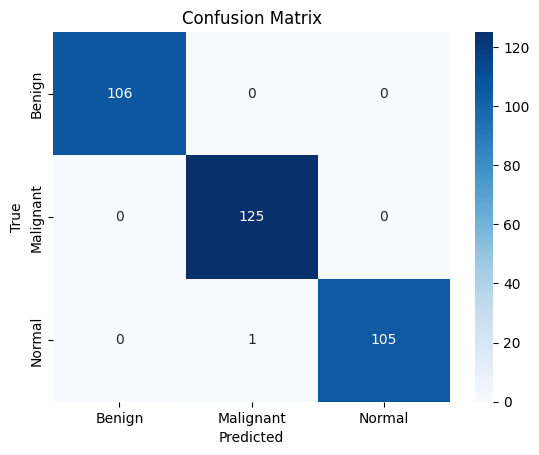


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       0.99      1.00      1.00       125
           2       1.00      0.99      1.00       106

    accuracy                           1.00       337
   macro avg       1.00      1.00      1.00       337
weighted avg       1.00      1.00      1.00       337



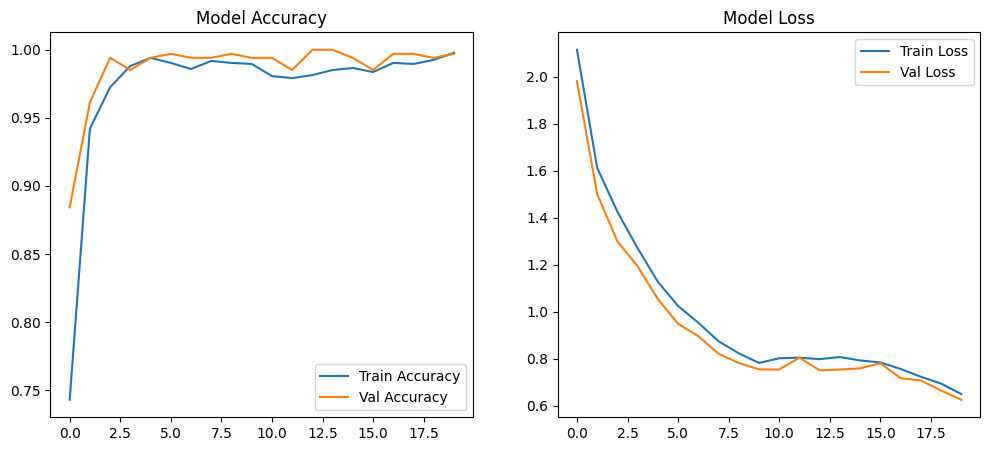

In [60]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant', 'Normal'],
            yticklabels=['Benign', 'Malignant', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Report
print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes))

# Training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend(); plt.title('Model Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Model Loss')
    plt.show()

plot_training_history(history)


In [74]:

# Define paths
benign_path = r"E:\IQ-OTHNCCD _Lung _Cancer_Dataset\Benign cases"
malignant_path = r"E:\IQ-OTHNCCD _Lung _Cancer_Dataset\Malignant cases"

# GLCM feature extractor
def extract_glcm_features(img):
    glcm = graycomatrix((img * 255).astype(np.uint8), distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))
    return contrast, entropy

cancer_image_paths = []
for folder in [benign_path, malignant_path]:
    cancer_image_paths.extend([os.path.join(folder, f) for f in os.listdir(folder)])

contrast_vals, entropy_vals = [], []
for path in cancer_image_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (64, 64)) / 255.0
        c, e = extract_glcm_features(img)
        contrast_vals.append(c)
        entropy_vals.append(e)

contrast_qs = np.percentile(contrast_vals, [25, 50, 75])
entropy_qs = np.percentile(entropy_vals, [25, 50, 75])

def get_stage_from_glcm_features(contrast, entropy, cancer_class):
    c_score = np.digitize(contrast, contrast_qs)
    e_score = np.digitize(entropy, entropy_qs)
    stage_score = (c_score + e_score) / 2

    if cancer_class == 0:
        return "Stage 1" if stage_score <= 1 else "Stage 2"
    elif cancer_class == 1:
        return "Stage 3" if stage_score <= 1 else "Stage 4"
    else:
        return "Normal"

def predict_cnn_class_and_stage(image_path, model, scaler):
    img = cv2.imread(image_path)
    if img is None:
        return "Invalid image path."

    # Preprocess
    img_resized = cv2.resize(img, (64, 64))
    img_norm = img_resized / 255.0
    img_input = img_norm.reshape(1, -1)
    img_input_scaled = scaler.transform(img_input)

    # Predict class
    class_probs = model.predict(img_input_scaled)
    class_pred = np.argmax(class_probs, axis=1)[0]

    if class_pred == 2:
        return "Prediction: Normal (No Cancer)\n\nExpected Prognosis: Normal individuals are not affected by lung cancer. Maintain regular checkups."

    # Stage estimation
    gray_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) / 255.0
    contrast, entropy = extract_glcm_features(gray_img)
    stage = get_stage_from_glcm_features(contrast, entropy, class_pred)
    class_name = "Benign" if class_pred == 0 else "Malignant"

    # Survival rate context
    survival_text = {
        "Stage 1": "Early detection with high potential for recovery.Estimated 5-year survival rate: 65% – 80%",
        "Stage 2": "Moderate risk, but still potentially treatable with surgery and therapy.Estimated 5-year survival rate: 40% – 55%",
        "Stage 3": "Cancer has spread regionally. Requires advanced treatments.Estimated 5-year survival rate: 20% – 35%",
        "Stage 4": "Cancer has metastasized to distant organs. Palliative care may be considered alongside treatment.Estimated 5-year survival rate: 5% – 10%"
    }.get(stage, "Consult your physician for more details.")

    return f"Prediction: {class_name} - {stage}\n\n{survival_text}\n\n⚠️ Note: This is an estimate based on general clinical statistics. Please consult a medical professional for a personalized prognosis."

# Example usage:
test_img_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Malignant cases\\Malignant case (200).jpg"
print(predict_cnn_class_and_stage(test_img_path, model, scaler))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Prediction: Malignant - Stage 4

Cancer has metastasized to distant organs. Palliative care may be considered alongside treatment.Estimated 5-year survival rate: 5% – 10%

⚠️ Note: This is an estimate based on general clinical statistics. Please consult a medical professional for a personalized prognosis.


In [78]:
test_img_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Malignant cases\\Malignant case (100).jpg"
print(predict_cnn_class_and_stage(test_img_path, model, scaler))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Prediction: Malignant - Stage 3

Cancer has spread regionally. Requires advanced treatments.Estimated 5-year survival rate: 20% – 35%

⚠️ Note: This is an estimate based on general clinical statistics. Please consult a medical professional for a personalized prognosis.


In [80]:
test_img_path = "E:\IQ-OTHNCCD _Lung _Cancer_Dataset\Benign cases\Bengin case (1).jpg"
print(predict_cnn_class_and_stage(test_img_path, model, scaler))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\vishn\AppData\Local\Temp\ipykernel_3052\1986339662.py:1: SyntaxWarning: invalid escape sequence '\I'
  test_img_path = "E:\IQ-OTHNCCD _Lung _Cancer_Dataset\Benign cases\Bengin case (1).jpg"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Prediction: Benign - Stage 2

Moderate risk, but still potentially treatable with surgery and therapy.Estimated 5-year survival rate: 40% – 55%

⚠️ Note: This is an estimate based on general clinical statistics. Please consult a medical professional for a personalized prognosis.


In [82]:
test_img_path = "E:\IQ-OTHNCCD _Lung _Cancer_Dataset\Benign cases\Bengin case (55).jpg"
print(predict_cnn_class_and_stage(test_img_path, model, scaler))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\vishn\AppData\Local\Temp\ipykernel_3052\3837324566.py:1: SyntaxWarning: invalid escape sequence '\I'
  test_img_path = "E:\IQ-OTHNCCD _Lung _Cancer_Dataset\Benign cases\Bengin case (55).jpg"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Prediction: Benign - Stage 1

Early detection with high potential for recovery.Estimated 5-year survival rate: 65% – 80%

⚠️ Note: This is an estimate based on general clinical statistics. Please consult a medical professional for a personalized prognosis.


In [76]:
def detect_overfitting(history, threshold=0.05):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    last_epoch = -1

    acc_gap = train_acc[last_epoch] - val_acc[last_epoch]
    loss_gap = val_loss[last_epoch] - train_loss[last_epoch]

    print(f"Final Train Accuracy: {train_acc[last_epoch]:.4f}")
    print(f"Final Val Accuracy:   {val_acc[last_epoch]:.4f}")
    print(f"Accuracy Gap:         {acc_gap:.4f}")
    print(f"Loss Gap:             {loss_gap:.4f}")

    if acc_gap > threshold:
        print("\n⚠️ Possible Overfitting Detected: High accuracy gap between training and validation.")
    else:
        print("\n✅ No significant overfitting detected.")

detect_overfitting(history)


Final Train Accuracy: 0.9978
Final Val Accuracy:   0.9970
Accuracy Gap:         0.0007
Loss Gap:             -0.0246

✅ No significant overfitting detected.


In [38]:
# Save the trained model to a file (HDF5 format)
model.save('lung_cancer_cnn_model.h5')  # 💾 This saves the model
print("✅ Model saved successfully as lung_cancer_cnn_model.h5")


✅ Model saved successfully as lung_cancer_cnn_model.h5


In [30]:
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np


In [39]:

scaler = StandardScaler()
scaler.fit(X_train) 


StandardScaler()

In [41]:
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

C:\Users\vishn\AppData\Local\Temp\ipykernel_24308\3949869238.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


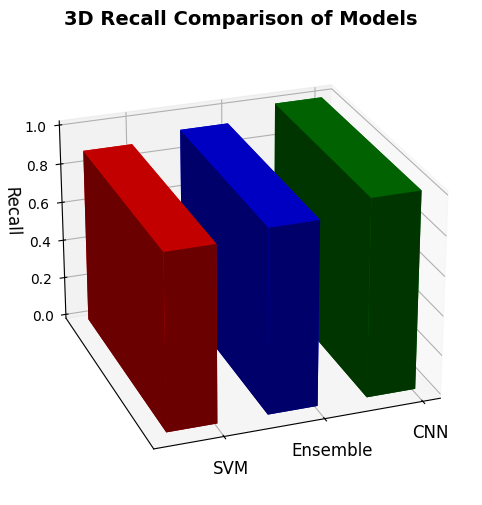

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Data
models = ['CNN', 'Ensemble', 'SVM']
accuracy = [1.00, 0.93, 0.89]

# Set up positions
x = np.arange(len(models))
y = np.zeros_like(x)  # y is constant
z = np.zeros_like(x)  # bar base
dx = dy = 0.5
dz = accuracy

# Colors for each bar
colors = ['green','blue','red']

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Create bars
for i in range(len(models)):
    ax.bar3d(x[i], y[i], z[i], dx, dy, dz[i], color=colors[i], shade=True)

# Set labels
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.set_yticks([])  # Hide y-axis ticks since we don't need them
ax.set_zlabel('Recall', fontsize=12)
ax.set_title('3D Recall Comparison of Models', fontsize=14, weight='bold')

# Add value labels on top of bars with adjusted vertical positioning
for i in range(len(models)):
    ax.text(x[i], y[i], dz[i] + 1.5, f'{dz[i]}%', ha='center', fontsize=12, color='black', weight='bold')

# Adjust the angle of the view for a better perspective
ax.view_init(elev=25, azim=70)

# Light background
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()


C:\Users\vishn\AppData\Local\Temp\ipykernel_24308\839774440.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


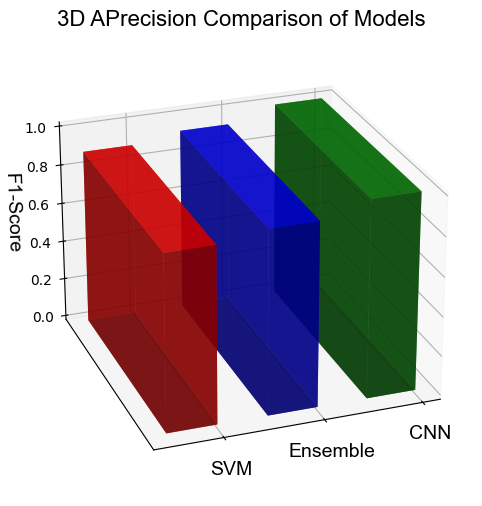

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Data
models = ['CNN', 'Ensemble','SVM']
accuracy = [1.00, 0.93, 0.89]

# Set up positions
x = np.arange(len(models))
y = np.zeros_like(x)  # y is constant
z = np.zeros_like(x)  # bar base
dx = dy = 0.5
dz = accuracy

# Colors for each bar with more appealing shades
colors = ['green','blue','red']  # Soft greens, peach, and light pink

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Create bars with transparency (alpha value)
for i in range(len(models)):
    ax.bar3d(x[i], y[i], z[i], dx, dy, dz[i], color=colors[i], shade=True, alpha=0.7)

# Set labels
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14,  family='Arial')
ax.set_yticks([])  # Hide y-axis ticks since we don't need them
ax.set_zlabel('F1-Score', fontsize=14, family='Arial')
ax.set_title('3D APrecision Comparison of Models', fontsize=16,  family='Arial')

# Add value labels on top of bars with adjusted vertical positioning
for i in range(len(models)):
    ax.text(x[i], y[i], dz[i] + 1.5, f'{dz[i]}%', ha='center', fontsize=10, color='black')

# Adjust the angle of the view for a better perspective
ax.view_init(elev=25, azim=70)

# Light background and clean axis lines
fig.patch.set_facecolor('white')


# Show plot with tight layout
plt.tight_layout()
plt.show()


C:\Users\vishn\AppData\Local\Temp\ipykernel_24308\4193985994.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


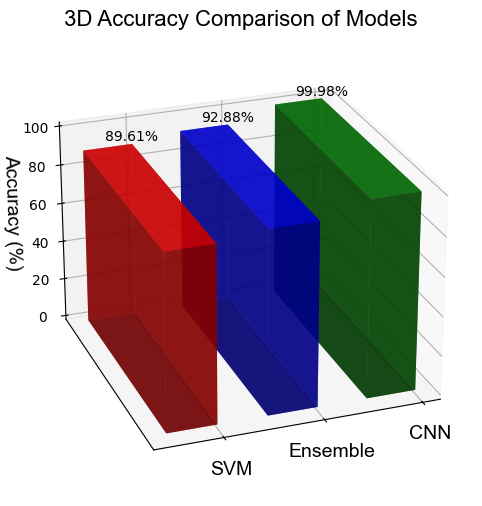

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Data
models = ['CNN', 'Ensemble','SVM']
accuracy = [99.98, 92.88, 89.61]

# Set up positions
x = np.arange(len(models))
y = np.zeros_like(x)  # y is constant
z = np.zeros_like(x)  # bar base
dx = dy = 0.5
dz = accuracy

# Colors for each bar with more appealing shades
colors = ['green','blue','red']  # Soft greens, peach, and light pink

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Create bars with transparency (alpha value)
for i in range(len(models)):
    ax.bar3d(x[i], y[i], z[i], dx, dy, dz[i], color=colors[i], shade=True, alpha=0.7)

# Set labels
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14,  family='Arial')
ax.set_yticks([])  # Hide y-axis ticks since we don't need them
ax.set_zlabel('Accuracy (%)', fontsize=14, family='Arial')
ax.set_title('3D Accuracy Comparison of Models', fontsize=16,  family='Arial')

# Add value labels on top of bars with adjusted vertical positioning
for i in range(len(models)):
    ax.text(x[i], y[i], dz[i] + 1.5, f'{dz[i]}%', ha='center', fontsize=10, color='black')

# Adjust the angle of the view for a better perspective
ax.view_init(elev=25, azim=70)

# Light background and clean axis lines
fig.patch.set_facecolor('white')


# Show plot with tight layout
plt.tight_layout()
plt.show()


C:\Users\vishn\AppData\Local\Temp\ipykernel_24308\3360944678.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


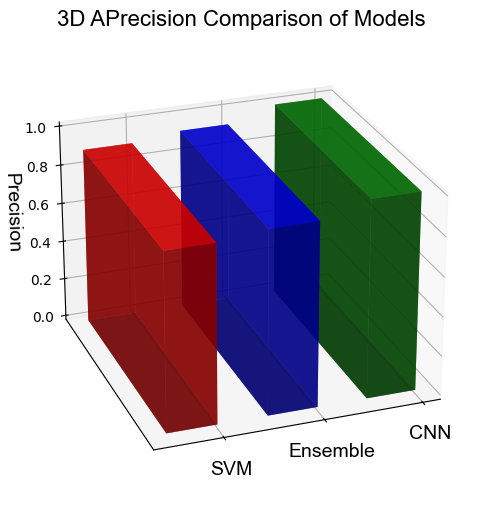

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Data
models = ['CNN', 'Ensemble','SVM']
accuracy = [1.00, 0.93, 0.90]

# Set up positions
x = np.arange(len(models))
y = np.zeros_like(x)  # y is constant
z = np.zeros_like(x)  # bar base
dx = dy = 0.5
dz = accuracy

# Colors for each bar with more appealing shades
colors = ['green','blue','red']  # Soft greens, peach, and light pink

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Create bars with transparency (alpha value)
for i in range(len(models)):
    ax.bar3d(x[i], y[i], z[i], dx, dy, dz[i], color=colors[i], shade=True, alpha=0.7)

# Set labels
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14,  family='Arial')
ax.set_yticks([])  # Hide y-axis ticks since we don't need them
ax.set_zlabel('Precision', fontsize=14, family='Arial')
ax.set_title('3D APrecision Comparison of Models', fontsize=16,  family='Arial')

# Add value labels on top of bars with adjusted vertical positioning
for i in range(len(models)):
    ax.text(x[i], y[i], dz[i] + 1.5, f'{dz[i]}%', ha='center', fontsize=10, color='black')

# Adjust the angle of the view for a better perspective
ax.view_init(elev=25, azim=70)

# Light background and clean axis lines
fig.patch.set_facecolor('white')


# Show plot with tight layout
plt.tight_layout()
plt.show()
